In [3]:

import numpy as np
from keras.models import Sequential
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.models import load_model
import tensorflow as tf

In [6]:
tf.test.is_gpu_available(
  cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [228]:
df=pd.read_csv('IDC Data and Analytics.csv')
df= df[:10000]
df.shape

(10000, 8)

In [229]:
def pre_process(data):
          data = data[["采集时间", "分配带宽(M)","数据中心ID", "业务ID", "入流量(M)", "出流量(M)"]]
          data= data.drop(['采集时间'], axis=1)
          data= data[data['入流量(M)'] !=0]
          return data
pre_process(df).shape

(10000, 5)

In [230]:
data_= pre_process(df)
data_

,分配带宽(M),数据中心ID,业务ID,入流量(M),出流量(M)
0,20,754669,1710158,0.53,1.02
1,20,754669,1710158,1.21,1.05
2,20,754669,1710158,1.19,1.06
3,20,754669,1710158,1.19,1.25
4,20,754669,1710158,2.30,1.04
...,...,...,...,...,...
9995,100000,754669,1721644,61369.73,24631.90
9996,100000,754669,1721644,62124.02,24576.70
9997,100000,754669,1721644,62273.27,24733.99
9998,100000,754669,1721644,60933.90,23587.70


In [231]:
def splitting_data(input_):
          #Splitting to training and testing, The first 70% data set goes to training and last 30% goes to testing
          data_training=pd.DataFrame(input_['入流量(M)'][0:int(len(data_)*0.70)])
          data_testing= pd.DataFrame(input_['入流量(M)'][int(len(data_)*0.7):int(len(data_))])
          
          return data_training, data_testing


In [232]:
data_training, data_testing = splitting_data(data_)
#check the training and testing size
print("Trainining size:",data_training.shape)
print("Testing size:",data_testing.shape)

Trainining size: (7000, 1)
Testing size: (3000, 1)


In [233]:
def data_scaling(splitted_data):
          #We scale down our data set between 0 and 1 
          scaler = MinMaxScaler(feature_range=(0,1))
          data_array=scaler.fit_transform(splitted_data)
          return data_array,scaler

In [234]:
data_training

,入流量(M)
0,0.53
1,1.21
2,1.19
3,1.19
4,2.30
...,...
6995,11424.82
6996,12261.82
6997,13294.79
6998,14160.46


In [235]:

data_training_array,scaler=data_scaling(data_training)


In [236]:
#create time series data
##Here We use simple time series analogy since we gonna look n number of data point back to predict m number of future data points
def time_series_data(Array):
          x_train = []
          y_train = []
          for i in range(2016,Array.shape[0]):
                    x_train.append(Array[i-2016:i])
                    y_train.append(Array[i,0]) 
                        
          return x_train,y_train
          
          

In [237]:
#change to numpy array
xtrain, ytrain = time_series_data(data_training_array)
x_train,y_train = np.array(xtrain),np.array(ytrain)
print(x_train.shape,y_train.shape)

(4984, 2016, 1) (4984,)


In [238]:
#We define our model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2016, 50)          10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 2016, 50)          20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [239]:
#compile our model with adam optimizer and mse error metrics
model.compile(optimizer='adam',loss=['mean_squared_error'])
model.fit(x_train,y_train,epochs = 10,batch_size=64)

Epoch 1/10
78/78 [==============================] - 275s 3s/step - loss: 0.0080
Epoch 2/10
78/78 [==============================] - 260s 3s/step - loss: 0.0019
Epoch 3/10
78/78 [==============================] - 261s 3s/step - loss: 0.0014
Epoch 4/10
78/78 [==============================] - 255s 3s/step - loss: 0.0012
Epoch 5/10
78/78 [==============================] - 258s 3s/step - loss: 0.0011
Epoch 6/10
78/78 [==============================] - 261s 3s/step - loss: 9.9798e-04
Epoch 7/10
78/78 [==============================] - 264s 3s/step - loss: 8.6698e-04
Epoch 8/10
78/78 [==============================] - 261s 3s/step - loss: 7.5310e-04
Epoch 9/10
78/78 [==============================] - 265s 3s/step - loss: 6.5788e-04
Epoch 10/10
78/78 [==============================] - 262s 3s/step - loss: 6.2638e-04


In [240]:
#we save our model to use it later
model.save('model1a.h5')

In [241]:
#our test data which is 30 percent of the whole dataset
data_testing=data_testing[:2016]
data_testing

,入流量(M)
7000,16089.13
7001,16865.39
7002,17738.63
7003,19059.76
7004,19697.08
...,...
9011,6014.53
9012,6022.23
9013,6387.36
9014,6243.99


In [242]:
#we use the testing data to predict the future data point. 
# But the first data point to be predicted always depend on the n number of past points.
#That n number of data point is used in training the model. 
# again the are gonna use as input to predict the first element of our prediction.
# Therefore we append the last n number of training data to our testing data which we use as imput data
def Create_test_data(testingdata):
          past_7_days=data_training.tail(2016)
          final_df = past_7_days.append(testingdata,ignore_index=True)
          input_data,scaler = data_scaling(final_df)
          return input_data,scaler

In [243]:
testing_data,scaler = Create_test_data(data_testing)
xtest, ytest = time_series_data(testing_data)
x_test,y_test = np.array(xtest), np.array(ytest)
y_test = y_test*scaler.scale_[0]

print("Input test:",x_test.shape,"Output test:",y_test.shape,"scaler:", scaler.scale_)

Input test: (2016, 2016, 1) Output test: (2016,) scaler: [1.54357386e-05]


/tmp/ipykernel_2048766/3732208241.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_7_days.append(testingdata,ignore_index=True)


In [244]:
#make prediction
def prediction(Xtest):
          model = load_model('model1a.h5')
          y_predicted = model.predict(Xtest)
          scaler_factor = scaler.scale_[0]
          y_predicted= y_predicted*scaler_factor
          return y_predicted


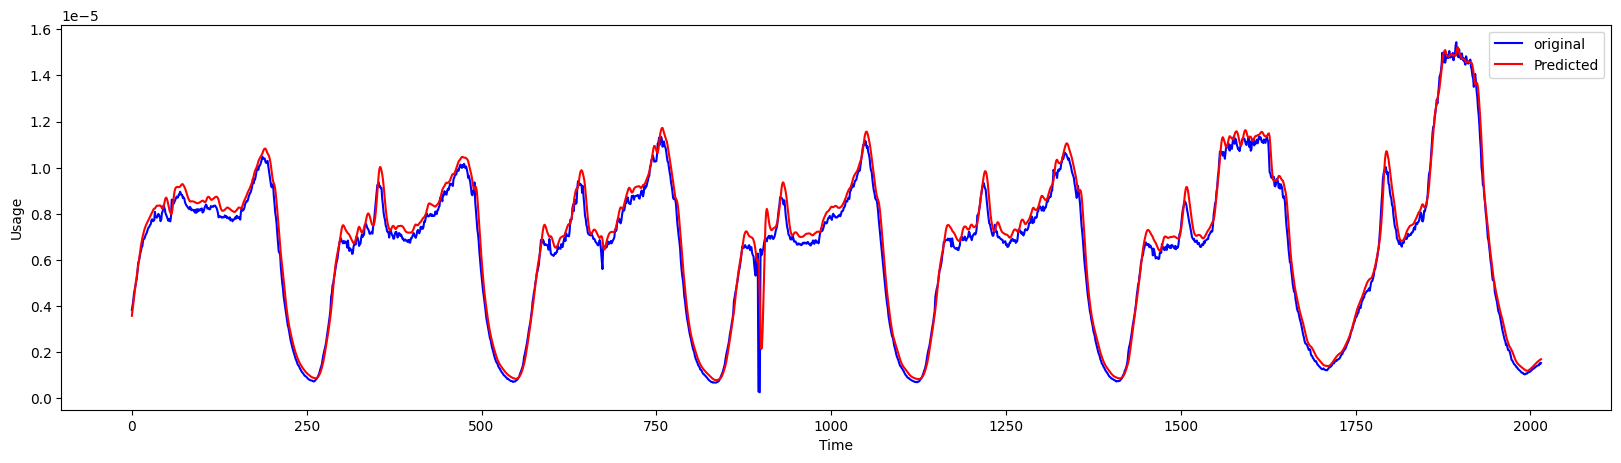

In [245]:
y_predicted=prediction(x_test)
plt.figure(figsize=(20,5))
plt.plot(y_test, 'b',label='original')
plt.plot(y_predicted, 'r',label='Predicted')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()


# How to Predict for diffirent company

The following is for 武汉英泰斯特有限公司	

In [246]:
df.head()

,数据中心ID,数据中心名称,业务ID,业务名称,分配带宽(M),采集时间,入流量(M),出流量(M)
0,754669,中国移动（武汉）东湖高新数据中心,1710158,武汉英泰斯特有限公司,20,2022-06-01 00:00:00,0.53,1.02
1,754669,中国移动（武汉）东湖高新数据中心,1710158,武汉英泰斯特有限公司,20,2022-06-01 00:05:00,1.21,1.05
2,754669,中国移动（武汉）东湖高新数据中心,1710158,武汉英泰斯特有限公司,20,2022-06-01 00:10:00,1.19,1.06
3,754669,中国移动（武汉）东湖高新数据中心,1710158,武汉英泰斯特有限公司,20,2022-06-01 00:15:00,1.19,1.25
4,754669,中国移动（武汉）东湖高新数据中心,1710158,武汉英泰斯特有限公司,20,2022-06-01 00:20:00,2.30,1.04


In [247]:
df['业务ID'].unique()

array([1710158, 1718232, 1721426, 1721644])

In [253]:
data1= df.loc[df['业务ID'] ==1721426]
data1=pre_process(data1)
data1

,分配带宽(M),数据中心ID,业务ID,入流量(M),出流量(M)
5760,50000,754669,1721426,40759.31,5652.00
5761,50000,754669,1721426,41488.77,5595.50
5762,50000,754669,1721426,41173.04,5672.25
5763,50000,754669,1721426,38092.75,5364.56
5764,50000,754669,1721426,37452.69,5197.85
...,...,...,...,...,...
8635,50000,754669,1721426,38557.09,4750.25
8636,50000,754669,1721426,38900.17,4680.85
8637,50000,754669,1721426,39923.60,4701.50
8638,50000,754669,1721426,39746.39,4697.68


In [254]:
data_testing1 = pd.DataFrame(data1['入流量(M)'])
data_testing1=data_testing1.tail(2016)
# data_testing1.shape

In [255]:
past_7_days=data_training.tail(2016)
final_df1 = past_7_days.append(data_testing1,ignore_index=True)
array_data1,scaler1 = data_scaling(final_df1)

/tmp/ipykernel_2048766/3325359585.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df1 = past_7_days.append(data_testing1,ignore_index=True)


In [256]:
xtest1, ytest1 = time_series_data(array_data1)
x_test1,y_test1 = np.array(xtest1), np.array(ytest1)
y_test1 = y_test1*scaler1.scale_[0]

print("Input test:",x_test1.shape,"Output test:",y_test1.shape,"scaler:", scaler1.scale_)

Input test: (2016, 2016, 1) Output test: (2016,) scaler: [2.09798734e-05]


/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27494 (\N{CJK UNIFIED IDEOGRAPH-6B66}) missing from current font.
  func(*args, **kwargs)
/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27721 (\N{CJK UNIFIED IDEOGRAPH-6C49}) missing from current font.
  func(*args, **kwargs)
/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  func(*args, **kwargs)
/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 27888 (\N{CJK UNIFIED IDEOGRAPH-6CF0}) missing from current font.
  func(*args, **kwargs)
/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from current font.
  func(*args, **kwargs)
/home/envs/ICD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 29305 (\N{CJK UN

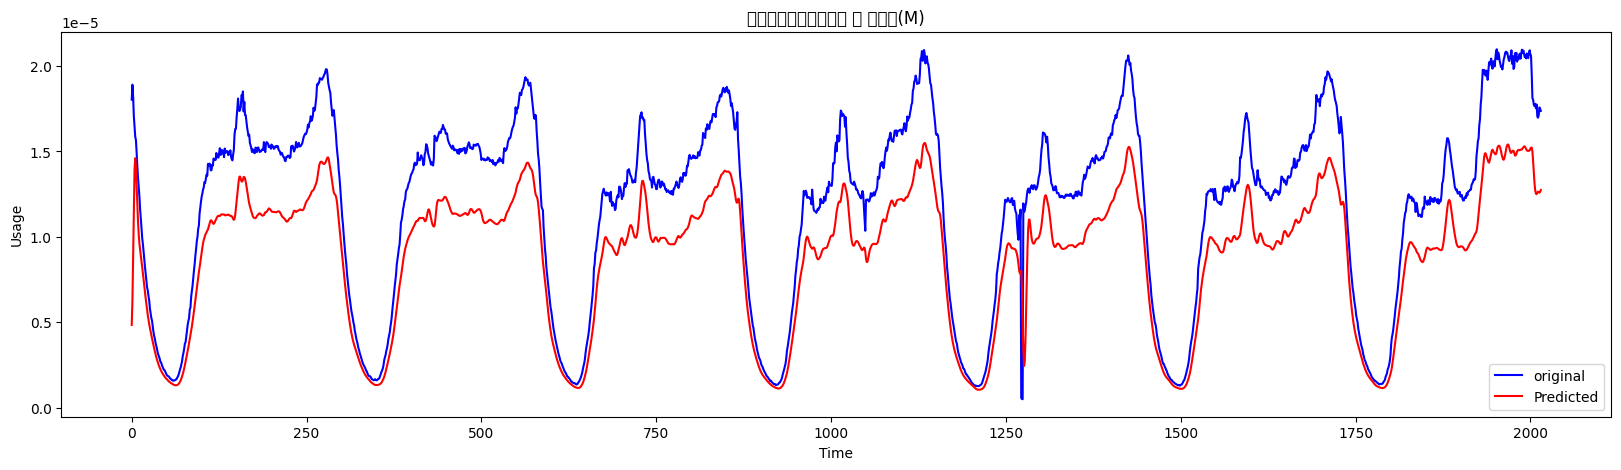

In [257]:
y_predicted1=prediction(x_test1)
plt.figure(figsize=(20,5))
plt.plot(y_test1, 'b',label='original')
plt.plot(y_predicted1, 'r',label='Predicted')
plt.title("武汉英泰斯特有限公司 的 入流量(M)")
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()